In [1]:
import os
import atexit
import sys
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SQLContext
import findspark
from sparkhpc import sparkjob
import pandas
from pyspark.sql import SparkSession

#Exit handler to clean up the Spark cluster if the script exits or crashes
def exitHandler(sj,sc):
    try:
        print('Trapped Exit cleaning up Spark Context')
        sc.stop()
    except:
        pass
    try:
        print('Trapped Exit cleaning up Spark Job')
        sj.stop()
    except:
        pass

findspark.init()

#Parameters for the Spark cluster
nodes=3
tasks_per_node=8 
memory_per_task=1024 #1 gig per process, adjust accordingly
# Please estimate walltime carefully to keep unused Spark clusters from sitting 
# idle so that others may use the resources.
walltime="2:00" #60 min 
os.environ['SBATCH_PARTITION']='lattice' #Set the appropriate ARC partition

sj = sparkjob.sparkjob(
     ncores=nodes*tasks_per_node,
     cores_per_executor=tasks_per_node,
     memory_per_core=memory_per_task,
     walltime=walltime
    )

try:
    print('Cleaning up Spark Job')
    sj.stop()
except:
    pass

sj.wait_to_start()

try:
    print('Cleaning up Spark Context')
    sc.stop()
except:
    pass

sc = sj.start_spark()

#Register the exit handler                                                                                                     
atexit.register(exitHandler,sj,sc)

#You need this line if you want to use SparkSQL
sqlCtx=SQLContext(sc)
print("RUNNING")

INFO:sparkhpc.sparkjob:Submitted batch job 699678

INFO:sparkhpc.sparkjob:Submitted cluster 0


Cleaning up Spark Job
Cleaning up Spark Context
RUNNING


In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from collections import defaultdict
from datetime import datetime

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
import emoji

In [3]:
# process the tweet and adds in negation terms
# adds a not to every word after a token of logical negation
# until the next puncutation mark
puncuation = {'"', ',', '.', '?', '!'}

# adapted from https://stackoverflow.com/questions/23384351/how-to-add-tags-to-negated-words-in-strings-that-follow-not-no-and-never
def check_and_negate(tweet: str):
    tweet = tweet.strip()
    # check if the end of the tweet has a puncuation mark and add if not
    if len(tweet) > 0 and tweet[-1] not in puncuation:
        tweet += '.'
    tweet = re.sub('n\'t', ' not', tweet) # replace n't with not
    tweet = re.sub('n’t', ' not', tweet)
    # add NOT_ to the beginning of each word until a end of sentence mark (.,!?) occurs
    tweet = re.sub(r'\b(?:not|never|no)\b[\'\w\s]+[.,?!"]', 
                   lambda match: re.sub(r'(\s+)(\w+)', r'\1not_\2', match.group(0)), 
                   tweet,
                   flags=re.IGNORECASE)
    return tweet

# remove stop words
stop_words = set(stopwords.words('english'))

# words used in the filter
filterWords = {"tesla", "elon", "musk", "elonmusk", "tsla", "roadster", "supercharger", "powerwall", "powerpack", "modely",
               "model3", "modelx", "teslamodely", "teslamodels", "teslamodel3", "teslamodelx", "spacex",
               "teslasuv", "teslascience"}

# bigrams used in the filter
filterBigrams = {("model", "y"), ("model", "s"), ("model", "3"), ("model", "x"), ("electric", "vehicle"),
                 ("electric", "car"), ("electric", "suv"), ("electric", "supercar")}

# stop words found using the word cloud (manual extraction)
cloud = {'year', 'amp', 'us', 'one', 'think'}

# add filter words to the stop words
for word in filterWords:
    stop_words.add(word)
    
# add filter bigrams to the stop words
for bi1, bi2 in filterBigrams:
    stop_words.add(bi1)
    stop_words.add(bi2)
    
# add cloud to the stop words
for word in cloud:
    stop_words.add(word)

tokenizer = RegexpTokenizer(r'\w+') # remove punctuation and keep only words
lemmatizer = WordNetLemmatizer()

def remove_stop_and_stem(tweet: str):
    words = []
    tokens = tokenizer.tokenize(tweet)
    for token in tokens:
        if token not in stop_words: # remove stopwords
            stemmed = lemmatizer.lemmatize(token) # stem the word
            if stemmed not in words: # ensure only unique words for binary naive bayes
                words.append(stemmed)
    return ' '.join(words)

# http://www.aclweb.org/anthology/W16-2610

# transform emojis into text
def transform_emojis(tweet: str):
    result = ''
    for character in tweet:
        temp = character
        if temp in emoji.UNICODE_EMOJI:
            temp = ' emoji_' + emoji.demojize(temp)[1:-1]
        result += temp
    return result

# processes the tweet
# https://towardsdatascience.com/the-real-world-as-seen-on-twitter-sentiment-analysis-part-one-5ac2d06b63fb
def process_tweet(tweet: str):
    tweet = tweet.lower() # convert to lowercase
    tweet = re.sub('#', '', tweet) # remove hashtags
    tweet = re.sub('@tesla', 'at_tesla', tweet) # change @Tesla to at_tesla
    tweet = re.sub('@elonmusk', 'elonmusk', tweet) # change @elonmusk to at_elonmusk
    tweet = re.sub('@\S+', '', tweet) # remove @username
    tweet = re.sub('\s+', ' ', tweet) # remove multiple whitespace
    # https://stackoverflow.com/questions/6038061/regular-expression-to-find-urls-within-a-string
    tweet = re.sub('(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', tweet) # remove links
    tweet = transform_emojis(tweet) # transform emojis
    tweet = check_and_negate(tweet)# add negations
    tweet = remove_stop_and_stem(tweet) # remove stop words and stem
    tweet.strip() # remove excess leading and trailing whitespace
    return tweet

def filter_text(tweet: str):
    # convert json object into python dict
    item = json.loads(tweet)
    if 'text' in item: # check that the dictionary contains the key
        return True
    else:
        return False

def parse_then_process(tweetObject: str):
    item = json.loads(tweetObject) # read the tweet object
    item['text'] = process_tweet(item['text']) # process the tweet text
    return json.dumps(item)

In [4]:
##SENTIMENT PREPROCESSING
stop_words_sent = {'elonmusk', 'tesla', 'get', 'at_tesla', 'at_elonmusk'}
tokenizer_sent = RegexpTokenizer(r'\w+') # remove punctuation and keep only words

def remove_stop_sent(tweet: str):
    words = []
    tokens = tokenizer_sent.tokenize(tweet)
    for token in tokens:
        if token not in stop_words_sent:
            words.append(token)
    return ' '.join(words)

def process_tweet_sent(tweet: str):
    tweet = tweet.lower() # convert to lowercase
    tweet = re.sub('\s+', ' ', tweet) # remove multiple whitespace
    tweet = remove_stop_sent(tweet)
    tweet.strip() # remove excess leading and trailing whitespace
    return tweet

def parse_then_process_sent(tweetObject: str):
    item = json.loads(tweetObject) # read the tweet object
    item['text'] = process_tweet_sent(item['text']) # process the tweet text
    return json.dumps(item)

In [5]:
#Load in labeled tweets
rddLabeled = sc.textFile("../Data/CombinedLabeled.json")

In [6]:
#Extract text and relevance label
def getRelLabel(line):
    jline = json.loads(line)
    return (jline['text'], int(jline['isRelevant']))
##Preprocess text for relevance classifier
rddRelProcessed = rddLabeled.map(parse_then_process)
relLabels = rddRelProcessed.map(getRelLabel)
firstLabel = relLabels.first()
print("Text: ", firstLabel[0], "\nRelevance Label:", firstLabel[1])

Text:  destination charger charge normal car 7kw super network c 
Relevance Label: 1


In [7]:
##Fit relevant classification model
pipeRelevant = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('mnb', MultinomialNB(fit_prior=False)),])
relData = relLabels.collect()
trainText = [i[0] for i in relData]
trainLabel = [i[1] for i in relData]
modelRelevant = pipeRelevant.fit(trainText, trainLabel)

In [8]:
#Extract text and sentiment label
#0 = negative, 1 = neutral, 2 = positive
def isRelevant(line):
    jline = json.loads(line)
    if int(jline['isRelevant']):
        return True
    return False

def getSentLabel(line):
    jline = json.loads(line)
    return (jline['text'], int(jline['sentiment']))

##Preprocess text for sentiment classifier
rddRelevant = rddRelProcessed.filter(isRelevant)
rddSentProcessed = rddRelevant.map(parse_then_process_sent)

sentLabels = rddSentProcessed.map(getSentLabel)
firstLabel = sentLabels.first()
print("Text: ", firstLabel[0], "\nSentiment Label:", firstLabel[1])

Text:  destination charger charge normal car 7kw super network c 
Sentiment Label: 1


In [9]:
##Fit sentiment classification model
pipeSentiment = Pipeline([('vect', CountVectorizer()),
                          ('tfidf', TfidfTransformer()),
                          ('mnb', MultinomialNB(fit_prior=False)),])
sentData = sentLabels.collect()
trainText = [i[0] for i in sentData]
trainLabel = [i[1] for i in sentData]
modelSentiment = pipeSentiment.fit(trainText, trainLabel)

In [10]:
#Load in full filtered tweet set
rddFull = sc.textFile("../Data/allFiltered4.json")

In [11]:
##Process and extract text from set
def getText(line):
    jline = json.loads(line)
    return jline['text']
rddRelProcessed = rddFull.map(parse_then_process)

In [12]:
#Make predictions on relevant tweets
def classifyRelevance(line):
    jline = json.loads(line)
    label = int(modelRelevant.predict((jline['text'],))[0])
    jline['isRelevant'] = label
    return json.dumps(jline)

rddRelClassified = rddRelProcessed.map(classifyRelevance)

In [13]:
#Filter out irrelevant tweets
rddRelevant = rddRelClassified.filter(isRelevant)
print("Number of relevant tweets: ", rddRelevant.count())
#Pre process tweets for the classifier
rddSentProcessed = rddRelevant.map(parse_then_process_sent)

Number of relevant tweets:  10786


In [14]:
#Make sentiment predictions on relevant tweets
def classifySentiment(line):
    jline = json.loads(line)
    label = int(modelSentiment.predict((jline['text'],))[0])
    jline['sentiment'] = label
    return json.dumps(jline)

rddSentClassified = rddSentProcessed.map(classifySentiment)

In [15]:
##Take the timestamp and sentiment labels from the rdd
def extractSentimentAndTimestamp(line):
    jline = json.loads(line)
    sentiment = int(jline['sentiment'])
    timestamp = int(jline['timestamp_ms'])
    return (timestamp, sentiment)

timeSent = rddSentClassified.map(extractSentimentAndTimestamp).collect()

In [16]:
##Check that output is correct
for i in range(10):
    print(timeSent[i])

(1546372267107, 1)
(1546372485007, 2)
(1546372687470, 2)
(1546372970795, 2)
(1546372974975, 2)
(1546373494329, 2)
(1546373518711, 1)
(1546373635157, 2)
(1546374029442, 2)
(1546374526952, 0)


In [17]:
##convert timestamp to date
def convertMsToDate(timestamp):
    return datetime.utcfromtimestamp(int(timestamp)/1000).strftime('%Y-%m-%d')
dfSent = pd.DataFrame(timeSent, columns=['timestamp_ms', 'sentiment'])
dfSent['date'] = dfSent['timestamp_ms'].apply(convertMsToDate)
dfSent = dfSent.drop(['timestamp_ms'], axis = 1)
dfSent['sentiment'] = dfSent['sentiment'] -1
print(dfSent.head())
print(set(dfSent['sentiment']))

   sentiment        date
0          0  2019-01-01
1          1  2019-01-01
2          1  2019-01-01
3          1  2019-01-01
4          1  2019-01-01
{0, 1, -1}


In [18]:
sentSums = defaultdict(int)
for index, row in dfSent.iterrows():
    sentSums[row['date']] += row['sentiment']

dates=[]
sums=[]
for date, sumval in sentSums.items():
    dates.append(date)
    sums.append(sumval)

dfDateSent = pd.DataFrame(
    {'Date': dates,
     'Sentiment Sums': sums
    })
missingDates = ['2019-01-24', '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28', '2019-01-29']
missingDatesList = [[date, np.nan] for date in missingDates]
tempdf = pd.DataFrame(missingDatesList, columns=['Date', 'Sentiment Sums'])
dfDateSent = dfDateSent.append(tempdf, ignore_index=True)
dfDateSent = dfDateSent.sort_values(by=['Date'])

print(dfDateSent)

          Date  Sentiment Sums
6   2018-12-23           168.0
7   2018-12-24           207.0
26  2018-12-25           141.0
27  2018-12-26           176.0
28  2018-12-27           184.0
29  2018-12-28           190.0
4   2018-12-29           276.0
5   2018-12-30           153.0
20  2018-12-31           125.0
0   2019-01-01           120.0
1   2019-01-02           111.0
2   2019-01-03           116.0
3   2019-01-04            30.0
8   2019-01-05           105.0
9   2019-01-06           155.0
10  2019-01-07           199.0
11  2019-01-08           154.0
18  2019-01-09           179.0
19  2019-01-10           184.0
12  2019-01-12            44.0
13  2019-01-13            70.0
14  2019-01-14           125.0
15  2019-01-15           209.0
16  2019-01-16           108.0
17  2019-01-17           134.0
30  2019-01-18            58.0
31  2019-01-19            89.0
32  2019-01-20            86.0
33  2019-01-21            92.0
34  2019-01-22            99.0
35  2019-01-23             8.0
36  2019

In [19]:
#Read in stock prices
dfStock = pd.read_csv('../Data/tsla_stock.csv')
dfStock = dfStock.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1)
dfStock = dfStock.rename(index=str, columns={"Close": "TSLA Price"})
print(dfStock.head())

dfSpy = pd.read_csv('../Data/spy.csv')
dfSpy = dfSpy.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1)
dfSpy = dfSpy.rename(index=str, columns={"Close": "SPY Price"})
print(dfSpy.head())

         Date  TSLA Price
0  2018-12-24  295.390015
1  2018-12-26  326.089996
2  2018-12-27  316.130005
3  2018-12-28  333.869995
4  2018-12-31  332.799988
         Date   SPY Price
0  2018-12-24  234.339996
1  2018-12-26  246.179993
2  2018-12-27  248.070007
3  2018-12-28  247.750000
4  2018-12-31  249.919998


In [20]:
#Merge sentiment dataframe with stock price dataframe
dfMerged = dfDateSent.merge(dfStock, how='left', on='Date')
#dfMerged = dfMerged.set_index('Date')
print(dfMerged.head())

         Date  Sentiment Sums  TSLA Price
0  2018-12-23           168.0         NaN
1  2018-12-24           207.0  295.390015
2  2018-12-25           141.0         NaN
3  2018-12-26           176.0  326.089996
4  2018-12-27           184.0  316.130005


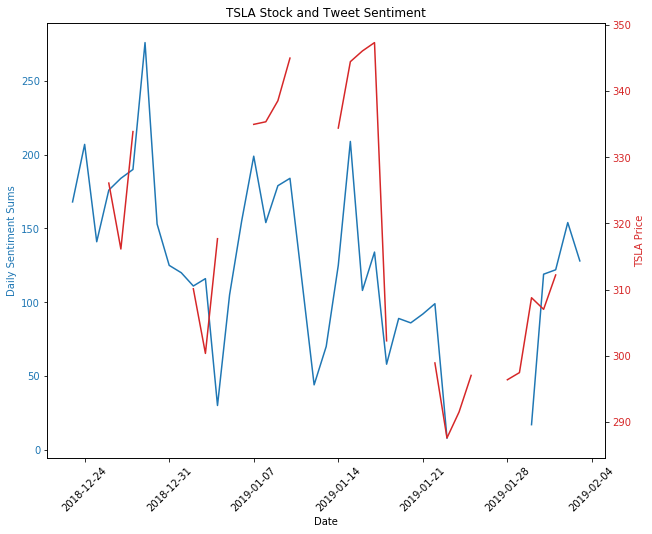

In [21]:
%matplotlib inline
x = dfMerged['Date']

x = [datetime.strptime(str(i), '%Y-%m-%d') for i in x]
y1 = dfMerged['Sentiment Sums']
y2 = dfMerged['TSLA Price']


fig, ax1 = plt.subplots(figsize=(10, 8))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Sentiment Sums', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('TSLA Price', color=color)  # we already handled the x-label with ax1
ax2.plot(x, y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
plt.title("TSLA Stock and Tweet Sentiment")
fig.savefig("aaafig.pdf")

In [22]:
#Merge sentiment dataframe with stock price dataframe
dfMerged = dfDateSent.merge(dfStock, how='left', on='Date')
dfMerged = dfMerged.merge(dfSpy, how='left', on='Date')
#dfMerged = dfMerged.set_index('Date')
print(dfMerged.head())

         Date  Sentiment Sums  TSLA Price   SPY Price
0  2018-12-23           168.0         NaN         NaN
1  2018-12-24           207.0  295.390015  234.339996
2  2018-12-25           141.0         NaN         NaN
3  2018-12-26           176.0  326.089996  246.179993
4  2018-12-27           184.0  316.130005  248.070007


Text(0.5,1,'TSLA Stock and SPY and Tweet Sentiment')

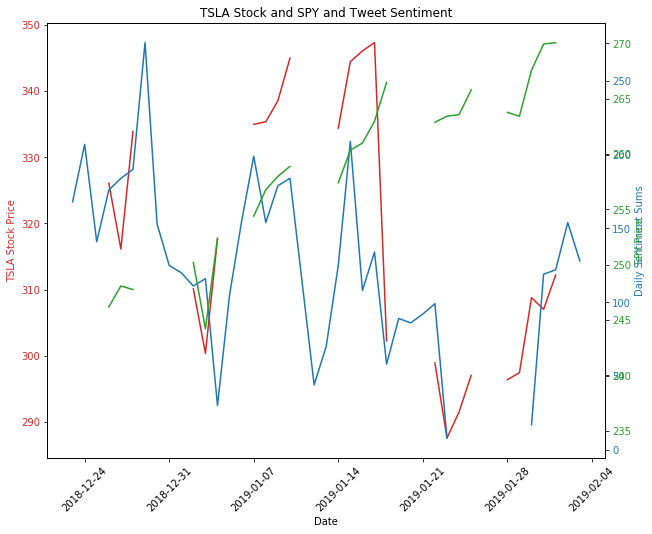

In [23]:
%matplotlib inline
x = dfMerged['Date']

x = [datetime.strptime(str(i), '%Y-%m-%d') for i in x]
y1 = dfMerged['TSLA Price']
y2 = dfMerged['Sentiment Sums']
y3 = dfMerged['SPY Price']

fig, ax1 = plt.subplots(figsize=(10, 8))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('TSLA Stock Price', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Daily Sentiment Sums', color=color)  # we already handled the x-label with ax1
ax2.plot(x, y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax3.set_ylabel('SPY Price', color=color)  # we already handled the x-label with ax1
ax3.plot(x, y3, color=color)
ax3.tick_params(axis='y', labelcolor=color)

for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
plt.title("TSLA Stock and SPY and Tweet Sentiment")